In [56]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from shapely.wkt import loads
import shapely.wkt

#### Let's load the Nashville zipcode data and look at the first few rows
- geopandas reads files with the `read_file()` method
- The zipcode data was downloaded from https://data.nashville.gov/resource/72um-tmbe.json


In [4]:
zipcodes = gpd.read_file('../data/zipcodes.geojson')
print(zipcodes.crs)
zipcodes.head( )

EPSG:4326


,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ..."
4,37064,18,FRANKLIN,28995.828320601937,46969608.005737305,"MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ..."


In [5]:
type(zipcodes)

geopandas.geodataframe.GeoDataFrame

#### Now let's look at the difference between calling the first geometry variable.....


zipcodes.loc[0, 'geometry']

#### ...and printing it


print(zipcodes.loc[0, 'geometry'])

#### Plotting a GeoDataFrame is as easy as calling the GeoPandas .plot() function


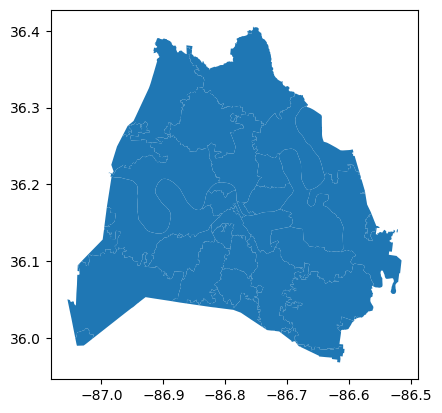

In [6]:
zipcodes.plot();

#### Add information and styling 
- set the `column =` to a column in the GeoDataFrame to color by
- change the [colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) 
- pass in keywords to tweak the legend created by [`matplotib`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)


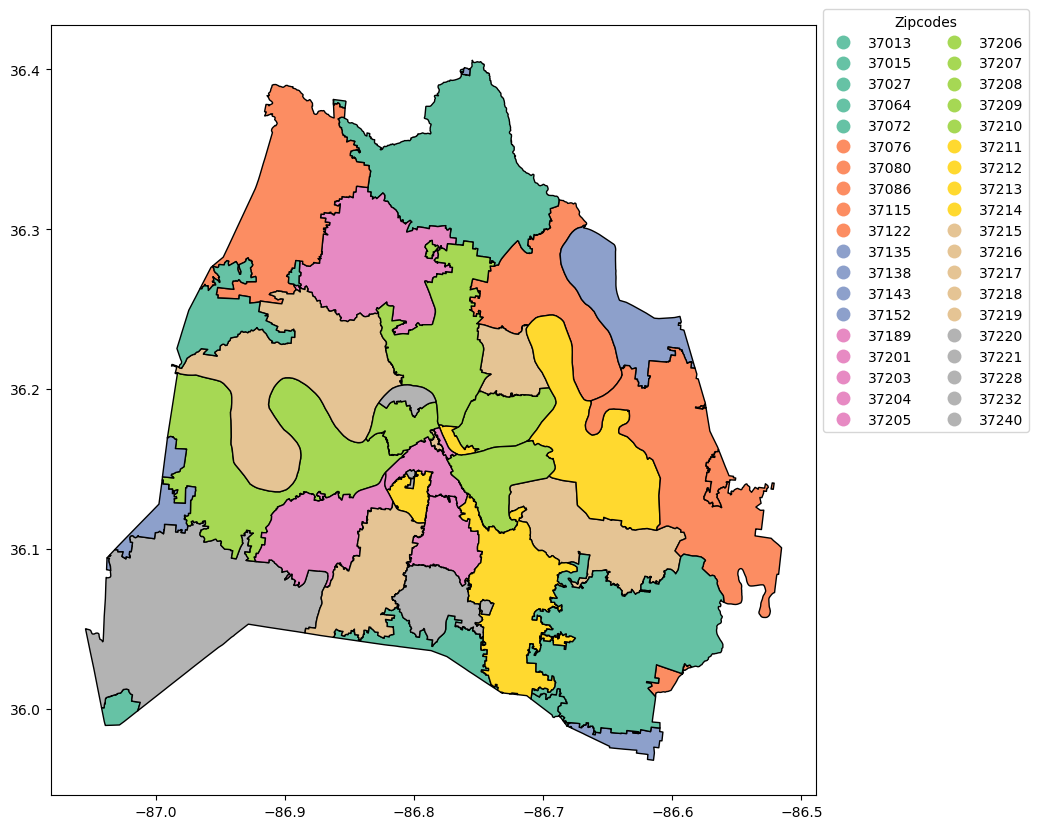

In [7]:
#geopandas handles legend styling if you pass a dict of keywords

leg_kwds = {'title': 'Zipcodes', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 2}

zipcodes.plot(column = 'zip', figsize=(10, 10),
              edgecolor = 'black',
              legend = True, legend_kwds = leg_kwds, 
              cmap = 'Set2')
plt.show()

#### Next you will read in the tonado sirens data 
- downloaded from https://data.nashville.gov/Emergency-Management/Tornado-Siren-Locations-Map-/wuw4-cqv8
- DID NOT CLEAN!:
- print the shape 
- take a look at the first 3 rows

In [6]:
tornado_sirens = pd.read_csv('../data/Tornado_Siren_locations.csv')
print(tornado_sirens.shape)
tornado_sirens.head(3)

(113, 9)


,Site Name,Address,City,ZIP Code,Siren,Radius,Mounted Height,Land Use Description,Mapped Location
0,Woodland St & Gay St,0 1ST AVE N,NASHVILLE,37201.0,Eclipse 8,4400,50,VACANT COMMERCIAL LAND,POINT (-86.776981 36.166543)
1,Watkins Park,616 17TH AVE N,NASHVILLE,37203.0,508,14700,50,PARK OR RECREATION,POINT (-86.799817 36.16229)
2,Alex Green Elementary,3921 LLOYD RD,WHITES CREEK,37189.0,Eclipse 8,4400,50,SCHOOL OR COLLEGE,POINT (-86.831647 36.252586)


In [7]:
tornado_sirens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Site Name             113 non-null    object 
 1   Address               113 non-null    object 
 2   City                  113 non-null    object 
 3   ZIP Code              111 non-null    float64
 4   Siren                 113 non-null    object 
 5   Radius                113 non-null    int64  
 6   Mounted Height        113 non-null    int64  
 7   Land Use Description  113 non-null    object 
 8   Mapped Location       113 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 8.1+ KB


In order to spatially join the bus stops with the zipcodes, you will need to create a GeoDataFrame of bus stops
First create a geometry column that is a Point datatype

In [21]:
tornado_sirens['geometry'] = tornado_sirens['Mapped Location'].apply(lambda x: loads(x))
tornado_sirens_geo = gpd.GeoDataFrame(tornado_sirens, geometry='geometry')
tornado_sirens_geo.crs = 'epsg:4326'

#### Now that the tornado sirens data has a geometry field, you can use it to build a GeoDataFrame 
- you want the CRS for the tornado sirens to match the CRS in the zipcodes GeoDataFrame 


In [8]:
zipcodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
tornado_sirens_geo.crs = zipcodes.crs

#### The `GeoDataFrame()` constructor needs 3 parameters:
 - a DataFrame
 - a coordinate reference system
 - a geometry

##nadosiren_geo = gpd.GeoDataFrame(bus_stops, 
                           crs = zipcodes.crs, 
                           geometry = bus_stops['geometry'])

##type(bus_geo)

#### Now you are ready to combine bus stops and zipcodes with a spatial join
- first a little clean up for the zipcodes
    - just keep the zip, po_name, and geometry columns
- then construct the join 
    - keep in mind that you want to find the bus stops within a zip code polygon
    - the geometry for the new (combined) GeoDataFrame comes from the left GeoDataFrame


In [23]:
print(zipcodes.crs)

EPSG:4326


In [24]:
print(tornado_sirens_geo.crs)

EPSG:4326


In [25]:
zipcodes = zipcodes[['zip', 'po_name', 'geometry']]

In [26]:
sirens_by_zip = gpd.sjoin(tornado_sirens_geo, zipcodes, predicate = 'within')

In [27]:
sirens_by_zip.head()

,Site Name,Address,City,ZIP Code,Siren,Radius,Mounted Height,Land Use Description,Mapped Location,geometry,index_right,zip,po_name
0,Woodland St & Gay St,0 1ST AVE N,NASHVILLE,37201.0,Eclipse 8,4400,50,VACANT COMMERCIAL LAND,POINT (-86.776981 36.166543),POINT (-86.77698 36.16654),36,37201,NASHVILLE
59,Riverfront Park,100 1ST AVE S,NASHVILLE,37201.0,Eclipse 8,4400,50,PARK OR RECREATION,POINT (-86.773944 36.162191),POINT (-86.77394 36.16219),36,37201,NASHVILLE
1,Watkins Park,616 17TH AVE N,NASHVILLE,37203.0,508,14700,50,PARK OR RECREATION,POINT (-86.799817 36.16229),POINT (-86.79982 36.16229),35,37203,NASHVILLE
14,Fort Negley,534 CHESTNUT ST,NASHVILLE,37203.0,Eclipse 8,4400,50,PARK OR RECREATION,POINT (-86.77574 36.142765),POINT (-86.77574 36.14276),35,37203,NASHVILLE
38,Centennial Park,2500 WEST END AVE,NASHVILLE,37203.0,Eclipse 8,4400,50,PARK OR RECREATION,POINT (-86.811924 36.148852),POINT (-86.81192 36.14885),35,37203,NASHVILLE


#### Now that the data is joined spatially you can count the sirens by zip code  and see how many stops are within each polygon 
- using the `value_counts()` method


In [28]:
sirens_by_zip['zip'].value_counts()

zip
37013    9
37211    9
37221    7
37207    7
37214    6
37217    6
37209    5
37205    5
37203    5
37218    5
37076    4
37215    4
37115    4
37206    4
37210    4
37072    4
37138    3
37208    3
37204    3
37189    3
37216    3
37201    2
37220    2
37080    2
37027    2
37228    1
37212    1
Name: count, dtype: int64

In [31]:
sirens_in_37013 = sirens_by_zip.loc[sirens_by_zip['zip'] == '37013']
sirens_in_37013.shape

(9, 13)

In [33]:
polygon37013 = zipcodes.loc[zipcodes['zip'] == '37013']
polygon37013.shape

(1, 3)

#### Now plot these two together
- first plot the polygons for 37013 and make them light blue
- next plot the points for the bus stops and color them by route

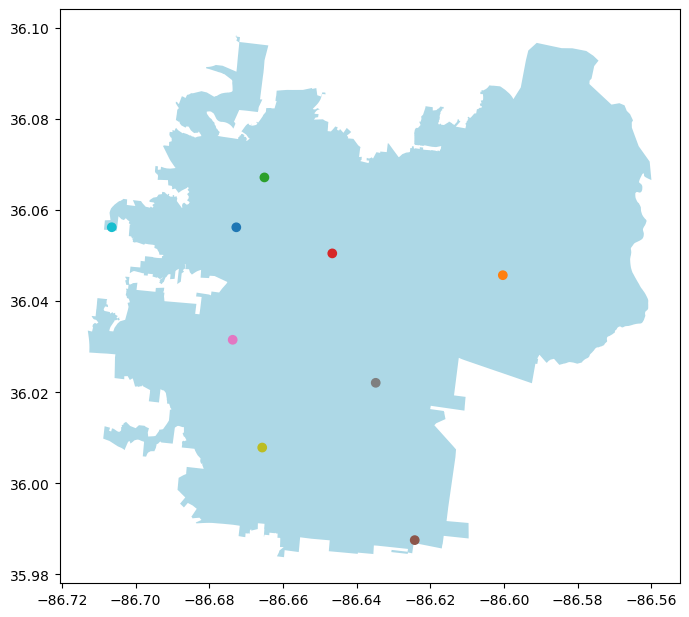

In [42]:
#fig, ax = matplotlib.subplots()
ax = polygon37013.plot(figsize = (8, 10), color = 'lightblue')
sirens_in_37013.plot( ax = ax, column = 'Site Name');
plt.show();

#### We're getting there! It would be helpful to have streets, though wouldn't it? We can add a street map with the folium package.

#### folium maps require a center point for the street map. 
- Make use of a GeoSeries attribute (.centroid) which gives the center of a polygon
- Since there are two polygons which should we use?

In [44]:
polygon37013.geometry.centroid

C:\Users\brand\AppData\Local\Temp\ipykernel_21888\3672746340.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon37013.geometry.centroid


51    POINT (-86.63636 36.04177)
dtype: geometry

In [48]:
center=polygon37013.geometry.centroid

C:\Users\brand\AppData\Local\Temp\ipykernel_21888\4062358415.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center=polygon37013.geometry.centroid


#### Folium requires a location point as an array 
- with *latitude* first
- but shapely Points have *longitude* first 

In [49]:
# reverse the order when constructing the array for folium location
area_center = [center.y, center.x]

# check the order of area_center, the location for our folium map
print(area_center)

[51    36.041767
dtype: float64, 51   -86.636359
dtype: float64]


#### To create a folium map just call the folium `Map()` constructor
- `location` is the only argument required by the constructor
    - Set `area_center` as the `location` of the folium map. 
- `zoom_start` is an optional argument 
    - A setting of 12 should get us nice and close

In [51]:
#create our map of Nashville Zip Code 37013 and show it
map_37013 = folium.Map(location =  area_center, zoom_start = 12)
map_37013

#### Next, let's add our 37013 polygon and bus stop markers.

#### `itterows()` is a generator that iterates through the rows of a DataFrame and returns a tuple with the row id and row values. 
- Below, we are printing the row values for the first 3 row as we iterate through the GeoDataFrame of sirens in 37013. 
- This idea will be helpful for creating our markers!

In [53]:
i = 0
for row_index, row_values in sirens_in_37013.iterrows():
    if i <3: 
        print('index is', row_index)
        print('values are:')
        print(' ')
        print(row_values)
        print('------------------------- ')
        i+=1

index is 3
values are:
 
Site Name                 Bell Road @ Bell Forge Rd
Address                        5432 BELL FORGE LN E
City                                        ANTIOCH
ZIP Code                                    37013.0
Siren                                     Eclipse 8
Radius                                         4400
Mounted Height                                   50
Land Use Description          STRIP SHOPPING CENTER
Mapped Location         POINT (-86.646603 36.05049)
geometry                POINT (-86.646603 36.05049)
index_right                                      51
zip                                           37013
po_name                                     ANTIOCH
Name: 3, dtype: object
------------------------- 
index is 18
values are:
 
Site Name               OHB @ Pettus Road (Woodbine Baptist)
Address                               13951 OLD HICKORY BLVD
City                                                 ANTIOCH
ZIP Code                                

#### Create map_37013 again with additional features:
- add the zipcode area outline (polygon_37013)
- iterate through the stops_in_37013 to
    - create location from each lat and lng
    - create a popup from the stop column
    - create a custom icon if you want with [font-awesome](https://fontawesome.com/v4.7.0/icons/)
      bell <i class="fa fa-bell" aria-hidden="true"></i>

    - build a marker from each location and popup and (optionally) your custom icon 
    - add the marker to  `map_37013`
- display `map_37013`

In [57]:
# Extract the center of the polygon
area_center = [polygon37013.geometry.centroid.y, polygon37013.geometry.centroid.x]

# Create the map with the polygon
map_37013 = folium.Map(location=area_center, zoom_start=12)
folium.GeoJson(polygon37013).add_to(map_37013)

# Iterate through sirens_in_37013 to create markers for each siren
for row_index, row_values in sirens_in_37013.iterrows():
    location_str = row_values['Mapped Location']
    location = shapely.wkt.loads(location_str)
    lat = location.y
    lng = location.x
    popup = row_values['Siren']
    icon = folium.Icon(color="red", icon="bell", prefix='fa')

    marker = folium.Marker(
        location=[lat, lng],
        popup=popup,
        icon=icon
    )

    marker.add_to(map_37013)

# Save the map as an HTML file
map_37013.save('../maps/map37013.html')

# Display the map
map_37013

C:\Users\brand\AppData\Local\Temp\ipykernel_21888\2869953967.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_center = [polygon37013.geometry.centroid.y, polygon37013.geometry.centroid.x]
C:\Users\brand\AppData\Local\Temp\ipykernel_21888\2869953967.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_center = [polygon37013.geometry.centroid.y, polygon37013.geometry.centroid.x]
C:\Users\brand\anaconda3\envs\geospatial\lib\site-packages\folium\utilities.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
C:\Users\brand\anaconda3\envs\geospatial\lib\site-packages\folium\utilities.py:77: Fu

#### If you have a lot of markers, you might want to use marker clusters
- Folium has `MarkerCluster()` and `FastMarkerCluster()`
- Construct a `MarkerCluster()` 
    - construct a `MarkerCluster()` and `.add_to()` the map
    - when you loop through the data and create markers add those to the marker cluster
- Construct a `FastMarkerCluster()` by passing a list of locations

#### You can save your map as an html file and it will retain the interactive qualities

In [58]:
folium.Map?

In [28]:
cluster_map_37207 = folium.Map(location =  area_center, zoom_start = 12)

#create a marker cluster
marker_cluster = MarkerCluster().add_to(cluster_map_37207)

folium.GeoJson(polygon37207).add_to(cluster_map_37207)

# inside the loop add each marker to the cluster
for row_index, row_values in stops_in_37207.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['route'])
    icon=folium.Icon(color="blue",icon="bus", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

    
#save an interactive HTML map by calling .save()
cluster_map_37207.save('../maps/cluster37207.html')

cluster_map_37207  

In [29]:
#draw our zip code area: 37207
map_37207 = folium.Map(location =  area_center, zoom_start = 12)

folium.GeoJson(polygon37207).add_to(map_37207)

#create a list of locations and pass them to FastMarkerCluster()
locations = stops_in_37207[['lat', 'lng']].values.tolist()
map_37207.add_child(
    FastMarkerCluster(locations)
)



#display our map
map_37207